
## 📘 Phase 3 — Exploratory Data Analysis (EDA)



In [ ]:

# ================================================================
# 1) IMPORTS & CONFIG
# ================================================================
import json
import math
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (8, 4.8)
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.dpi"] = 120

# Paths — assumes notebook is in /notebooks relative to repo root
NB_PATH = Path.cwd().resolve()
REPO_ROOT = NB_PATH.parent
DATA = REPO_ROOT / "data"
RAW = DATA / "raw"
PROCESSED = DATA / "processed"
REPORTS = REPO_ROOT / "reports"
OUTPUTS = REPO_ROOT / "outputs"
FIGURES = OUTPUTS / "figures"
TABLES = OUTPUTS / "tables"
INSIGHTS = OUTPUTS / "insights"

# Ensure output dirs
for p in [OUTPUTS, FIGURES, TABLES, INSIGHTS]:
    p.mkdir(parents=True, exist_ok=True)

print("Repo root:", REPO_ROOT)

# --- Figure folders + helper -------------------------------------------------
FIG_DIRS = {
    "univariate":   FIGURES / "univariate",
    "temporal":     FIGURES / "temporal",
    "salary":       FIGURES / "salary",
    "geo":          FIGURES / "geo",
    "skills":       FIGURES / "skills",
    "relationships":FIGURES / "relationships",
    "outliers":     FIGURES / "outliers",
}
for d in FIG_DIRS.values():
    d.mkdir(parents=True, exist_ok=True)

def savefig(name: str, section: str, **kwargs):
    """
    Save the current matplotlib figure into:
    outputs/figures/{section}/{name}.png
    """
    path = FIG_DIRS.get(section, FIGURES)
    path.mkdir(parents=True, exist_ok=True)
    fp = path / f"{name}.png"
    plt.savefig(fp, bbox_inches="tight", dpi=150, **kwargs)
    print("💾 Saved figure →", fp)




## 🎯 Purpose & Goals

1. **Data Quality Recap** — completeness, duplicates, date validity  
2. **Univariate** — distributions of numeric/categorical features  
3. **Temporal** — how demand changes over time  
4. **Salary Landscape** — role, experience, remote vs onsite, location  
5. **Skills** — top skills, skill bundles (co‑occurrence), simple salary lift (descriptive)  
6. **Relationships** — correlations and group comparisons (non‑causal)  
7. **Outliers & Robustness** — what we cap/transform and why  
8. **Insights Summary** — Observation → Implication notes for the report & dashboard


In [2]:

# ================================================================
# 2) LOAD DATASETS
# ================================================================
def safe_read_csv(path: Path):
    try:
        df = pd.read_csv(path)
        print(f"✅ Loaded: {path} | shape={df.shape}")
        return df
    except Exception as e:
        print(f"⚠️ Could not read {path}: {e}")
        return None

master = safe_read_csv(PROCESSED / "cleaned_master.csv")

dq_report = None
dq_path = REPORTS / "data_quality_report.json"
if dq_path.exists():
    try:
        dq_report = json.loads(dq_path.read_text(encoding="utf-8"))
        print(f"✅ Loaded data quality report: {dq_path}")
    except Exception as e:
        print("⚠️ Failed to read data_quality_report.json:", e)

cat_profile = safe_read_csv(REPORTS / "profiling_categorical_snapshot.csv")
num_profile = safe_read_csv(REPORTS / "profiling_numeric_snapshot.csv")

assert master is not None, "cleaned_master.csv not found. Make sure Phase 2 outputs exist."
master.head(3)


✅ Loaded: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\data\processed\cleaned_master.csv | shape=(36167, 29)
✅ Loaded data quality report: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\data_quality_report.json
✅ Loaded: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\profiling_categorical_snapshot.csv | shape=(18, 5)
✅ Loaded: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\profiling_numeric_snapshot.csv | shape=(16, 9)


C:\Users\tdmne\AppData\Local\Temp\ipykernel_2860\2394270061.py:6: DtypeWarning: Columns (2,9,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


,work_year,job_title,job_category,salary_currency,salary,salary_in_usd,employee_residence,experience_level,employment_type,work_setting,...,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name,salary_local
0,2022.0,Machine Learning Engineer in office,Analysis,EUR,186597.0,136086.0,US,MI,CT,Remote,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.0,Statistician (Remote),ML/AI,JPY,110630.0,67982.0,JP,EX,FL,Remote,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022.0,Machine Learning Engineer,ML/AI,INR,61280.0,153309.0,UK,MI,CT,Hybrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## 🧾 Dataset Provenance & Assumptions

- **Unit of analysis**: each row ≈ one job posting  
- **Source**: merged & cleaned outputs from Phase 2 (`/data/processed/cleaned_master.csv`)  
- **Key feature groups**:  
  - Salaries: `salary_usd`, `salary_midpoint`  
  - Experience & employment: `experience_level`, `employment_type`, `work_setting`, `company_size`  
  - Geography: `employee_residence`, `company_location`  
  - Time: `posting_date`, and/or engineered `posting_year`, `posting_month`  
  - Skills: `required_skills` (comma‑separated), `skill_count`  
- **Interpretation note**: All relationships are **descriptive** (not causal).  


In [4]:

# ================================================================
# 3) HELPERS
# ================================================================
def winsorize_series(s: pd.Series, lower=0.01, upper=0.99):
    '''Clip extremes to reduce tail leverage without dropping rows.'''
    if s is None or s.empty:
        return s
    lo, hi = s.quantile(lower), s.quantile(upper)
    return s.clip(lower=lo, upper=hi)

def safe_datetime(s, fmt=None):
    '''Robust datetime parse.'''
    try:
        return pd.to_datetime(s, format=fmt, errors="coerce")
    except Exception:
        return pd.to_datetime(s, errors="coerce")

def ensure_cols(df: pd.DataFrame, cols):
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df

def explode_skills(df: pd.DataFrame, col="required_skills"):
    '''Return exploded frame with one skill per row; trims whitespace.'''
    if col not in df.columns: 
        return pd.DataFrame(columns=[*df.columns, col])
    tmp = df.dropna(subset=[col]).copy()
    tmp[col] = tmp[col].astype(str).str.split(",")
    tmp = tmp.explode(col)
    tmp[col] = tmp[col].astype(str).str.strip()
    tmp = tmp[tmp[col].ne("")]
    return tmp

def cooccurrence_matrix(skills_df: pd.DataFrame, col="required_skills", top_k=30):
    '''Compute skill co-occurrence for top_k skills (symmetric matrix).'''
    vc = skills_df[col].value_counts().head(top_k)
    top = vc.index.tolist()
    # Build mapping of posting -> set(top_skills)
    key_col = "job_id" if "job_id" in skills_df.columns else None
    if key_col:
        g = skills_df[skills_df[col].isin(top)].groupby(key_col)[col].agg(lambda x: set(x))
    else:
        # Fallback: pseudo-group by blocks to avoid full cross-join on large frames
        idx_series = skills_df[skills_df[col].isin(top)].reset_index().groupby("index")[col].agg(lambda x: set(x))
        g = idx_series

    skills_list = sorted(top)
    idx = {s:i for i,s in enumerate(skills_list)}
    M = np.zeros((len(skills_list), len(skills_list)), dtype=int)
    for sset in g:
        sset = list(sset)
        for i in range(len(sset)):
            for j in range(i, len(sset)):
                a, b = sset[i], sset[j]
                if a in idx and b in idx:
                    M[idx[a], idx[b]] += 1
                    if a != b:
                        M[idx[b], idx[a]] += 1
    cooc = pd.DataFrame(M, index=skills_list, columns=skills_list)
    return cooc


Rows, Cols: (36167, 31)

Dtypes:
 work_year                        float64
job_title                         object
job_category                      object
salary_currency                   object
salary                           float64
salary_in_usd                    float64
employee_residence                object
experience_level                  object
employment_type                   object
work_setting                      object
company_location                  object
company_size                      object
__source__                        object
job_id                            object
category                          object
job_description                   object
job_skill_set                     object
salary_usd                       float64
remote_ratio                     float64
required_skills                   object
education_required                object
years_experience                 float64
industry                          object
posting_date           

,completeness
job_description,0.032267
category,0.032267
job_skill_set,0.032267
job_category,0.124423
salary_in_usd,0.138248
work_setting,0.138248
salary,0.138248
work_year,0.138248
salary_local,0.414743
industry,0.829485


,completeness
posting_year,0.829485
job_id,0.861752
company_size,0.953908
experience_level,0.953908
salary_currency,0.953908
employee_residence,0.967733
company_location,0.967733
employment_type,0.967733
job_title,1.000000
__source__,1.000000


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\column_completeness.png


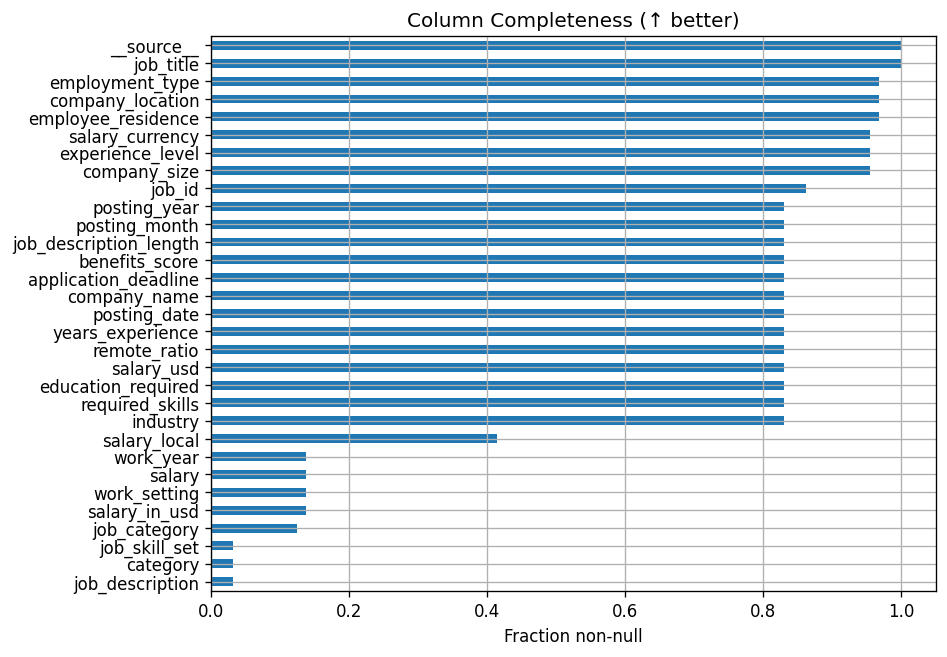

Duplicate rows: 0
Posting date range: 2024-01-01 00:00:00 → 2025-04-30 00:00:00
✅ Wrote: C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\reports\eda_summary.json


In [16]:
# ================================================================
# 4) DATA QUALITY OVERVIEW
# ================================================================
print("Rows, Cols:", master.shape)
print("\nDtypes:\n", master.dtypes)

# Completeness (% non-null)
comp = master.notna().mean().sort_values(ascending=True).rename("completeness")
comp.to_csv(TABLES / "eda_completeness.csv")
display(comp.to_frame().head(10))
display(comp.to_frame().tail(10))

# Missingness bar (matplotlib only)
ax = comp.plot(kind="barh",
               figsize=(8, max(4, len(comp)*0.18)),
               title="Column Completeness (↑ better)")
ax.set_xlabel("Fraction non-null")
plt.tight_layout()

# ✅ Save the figure before showing it
savefig("column_completeness", section="univariate")

plt.show()

# Duplicates
dups = int(master.duplicated().sum())
print(f"Duplicate rows: {dups}")

# Date validity window (if posting_date exists)
if "posting_date" in master.columns:
    master["posting_date"] = safe_datetime(master["posting_date"])
    dt_min, dt_max = master["posting_date"].min(), master["posting_date"].max()
    print("Posting date range:", dt_min, "→", dt_max)
else:
    print("No posting_date column detected.")

# Persist snapshot
summary = {
    "rows": int(len(master)),
    "cols": int(master.shape[1]),
    "duplicates": dups,
    "completeness_min10": comp.head(10).to_dict(),
    "date_range": {
        "min": str(master["posting_date"].min()) if "posting_date" in master.columns else None,
        "max": str(master["posting_date"].max()) if "posting_date" in master.columns else None,
    }
}
(REPORTS / "eda_summary.json").write_text(json.dumps(summary, indent=2))
print("✅ Wrote:", REPORTS / "eda_summary.json")



### 📌 Interpretation (Data Quality)
- Use **high‑coverage** columns (e.g., `salary_usd`, `experience_level`, `employment_type`, `company_location`, `required_skills`) for core analyses.  
- Avoid over‑reliance on **sparse** columns (e.g., long text JDs if coverage is low).  
- Document any exclusions (e.g., invalid or zero salaries) **before** plotting salary distributions.  


Numeric columns: ['work_year', 'salary', 'salary_in_usd', 'salary_usd', 'remote_ratio', 'years_experience', 'job_description_length', 'benefits_score', 'salary_local', 'posting_year', 'posting_month']
💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\work_year__hist_box.png


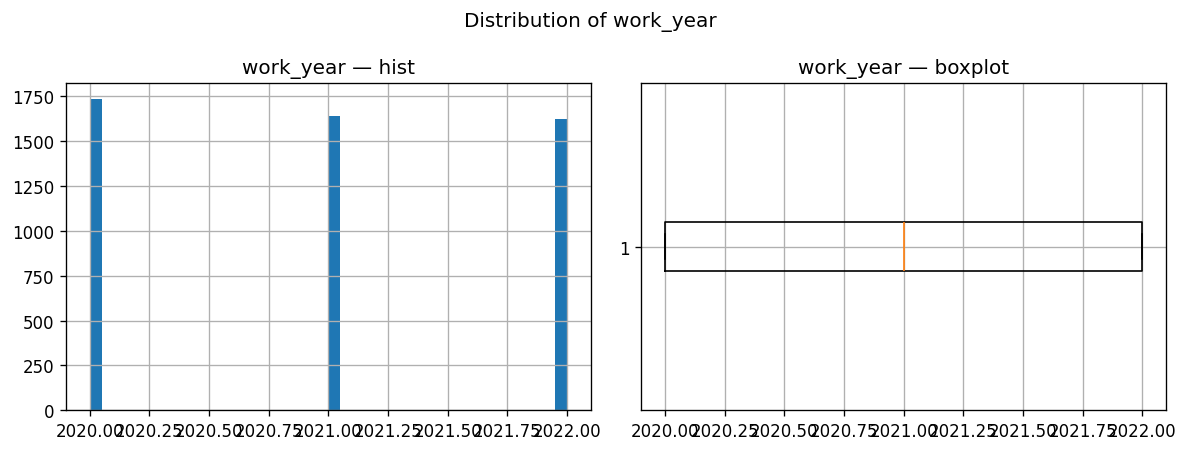

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\salary__hist_box.png


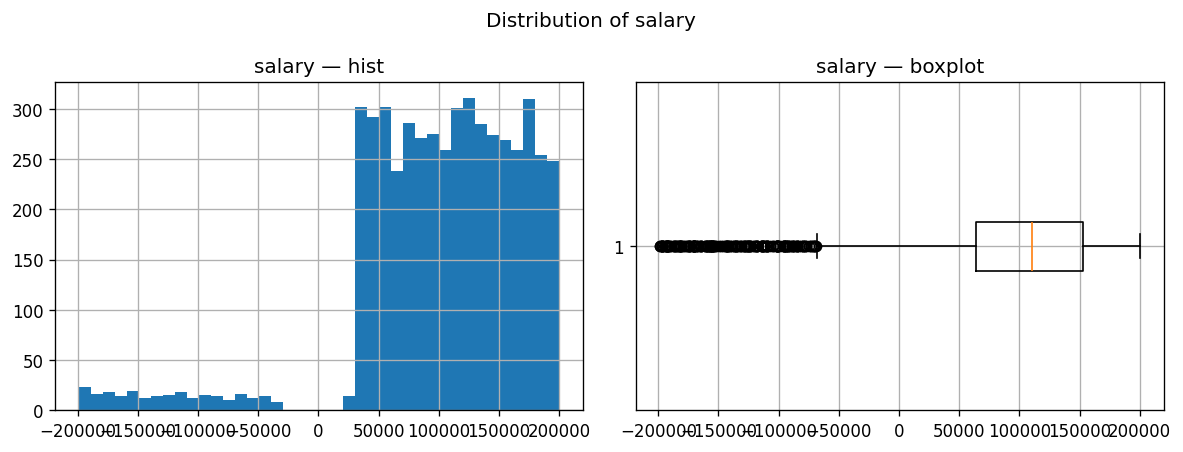

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\salary_in_usd__hist_box.png


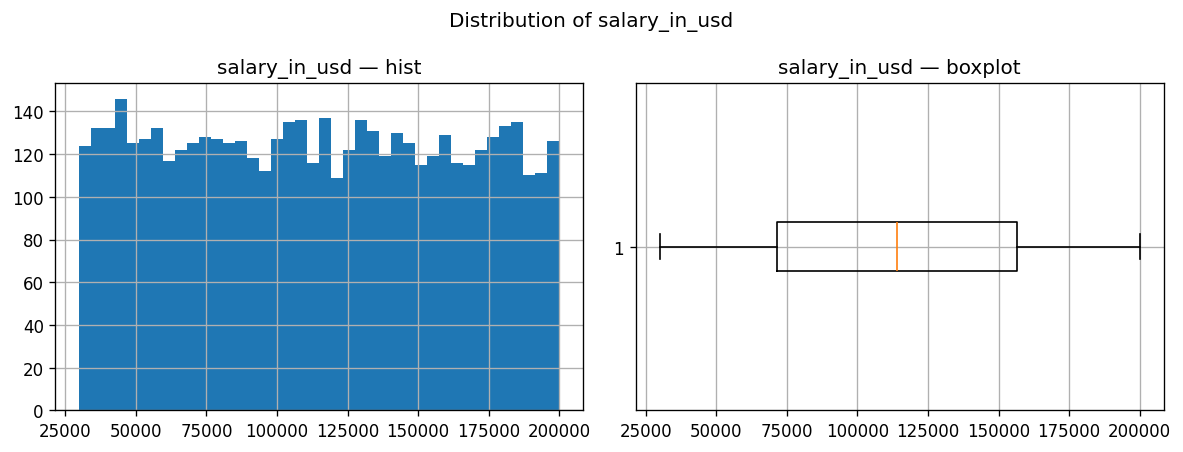

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\salary_usd__hist_box.png


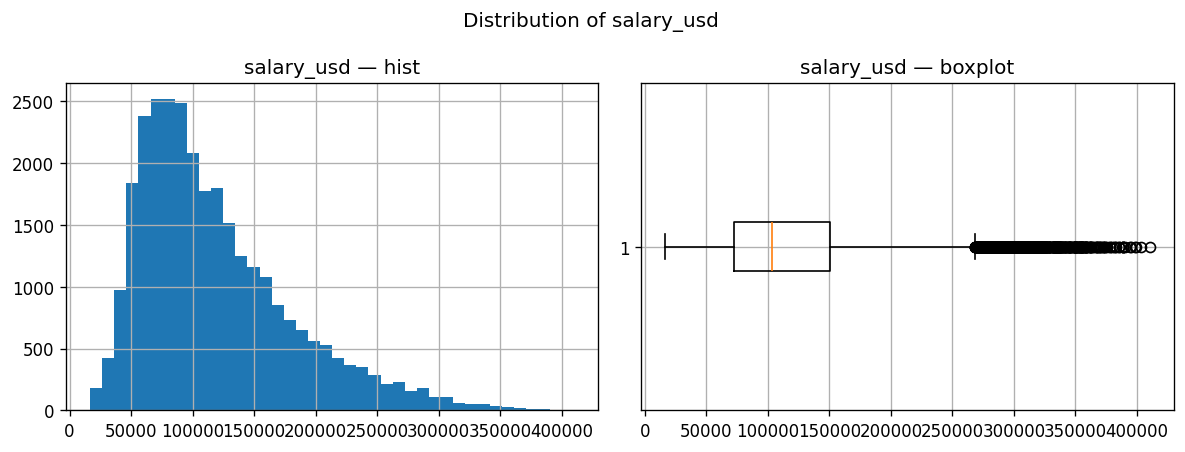

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\remote_ratio__hist_box.png


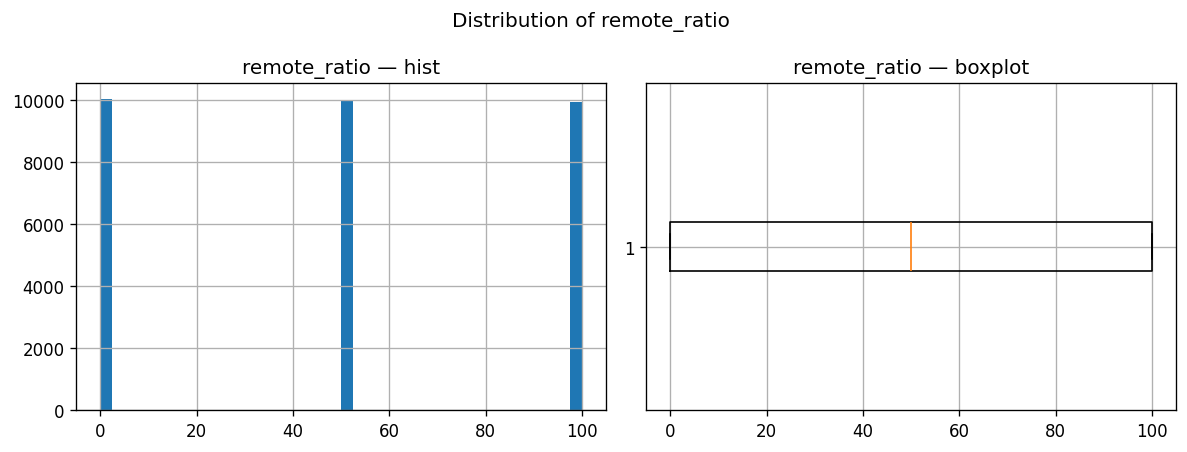

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\years_experience__hist_box.png


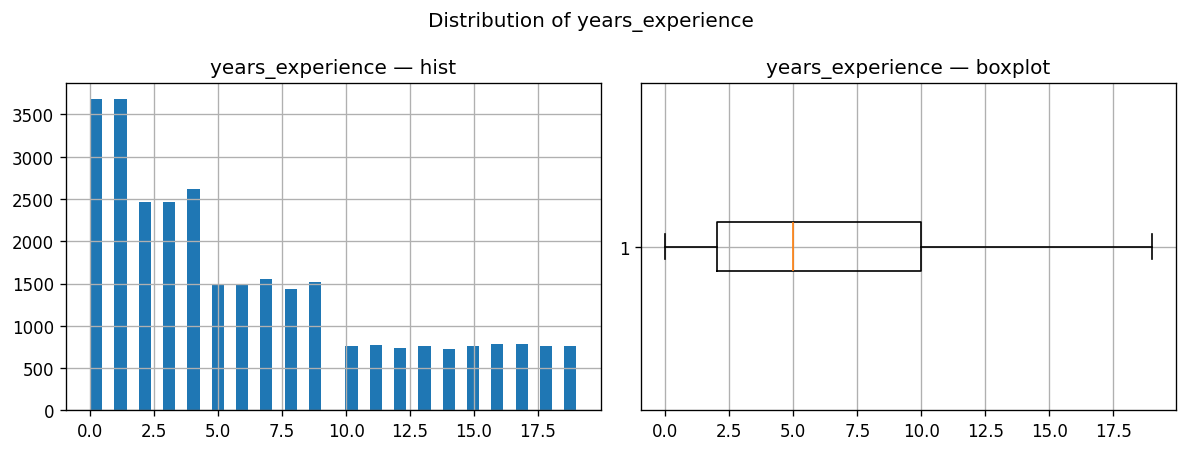

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\job_description_length__hist_box.png


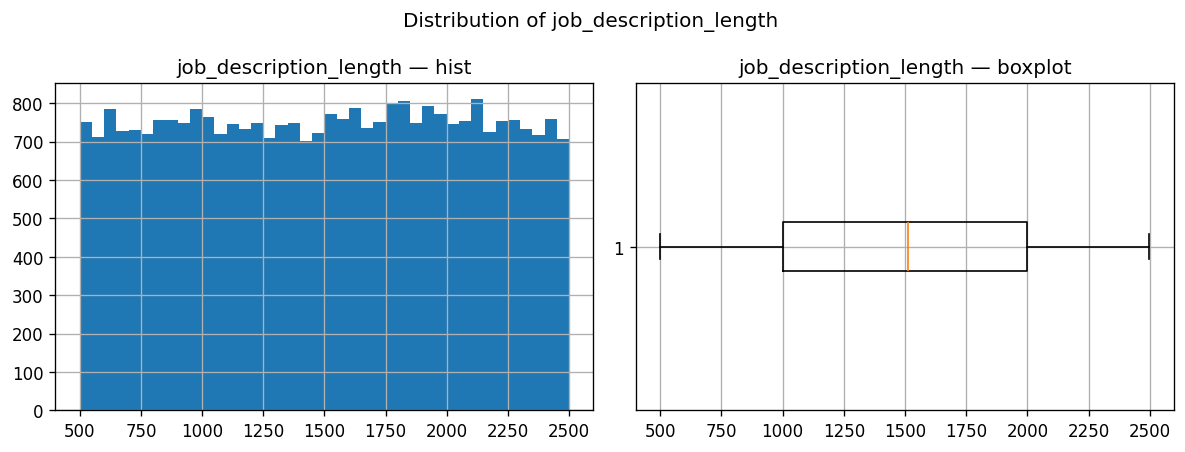

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\benefits_score__hist_box.png


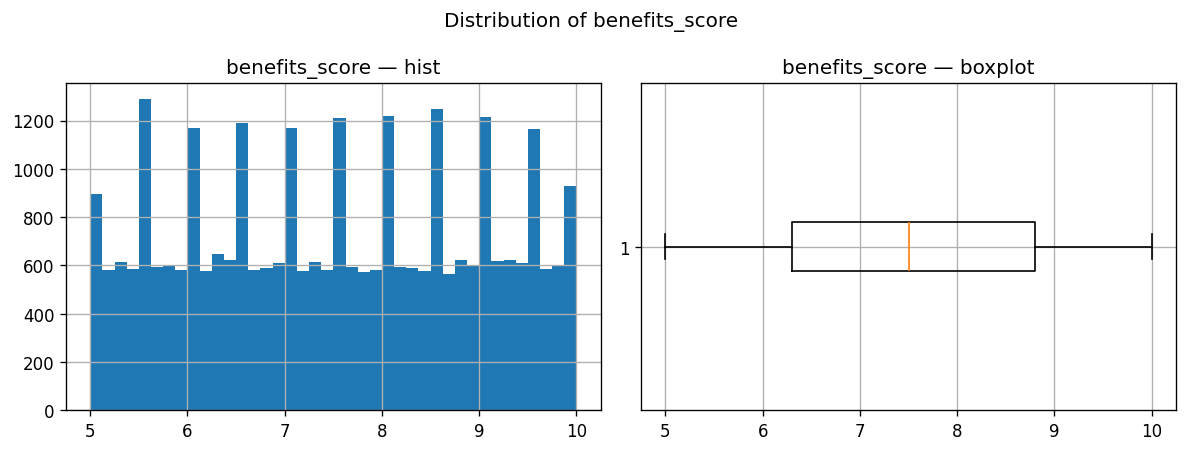

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\salary_local__hist_box.png


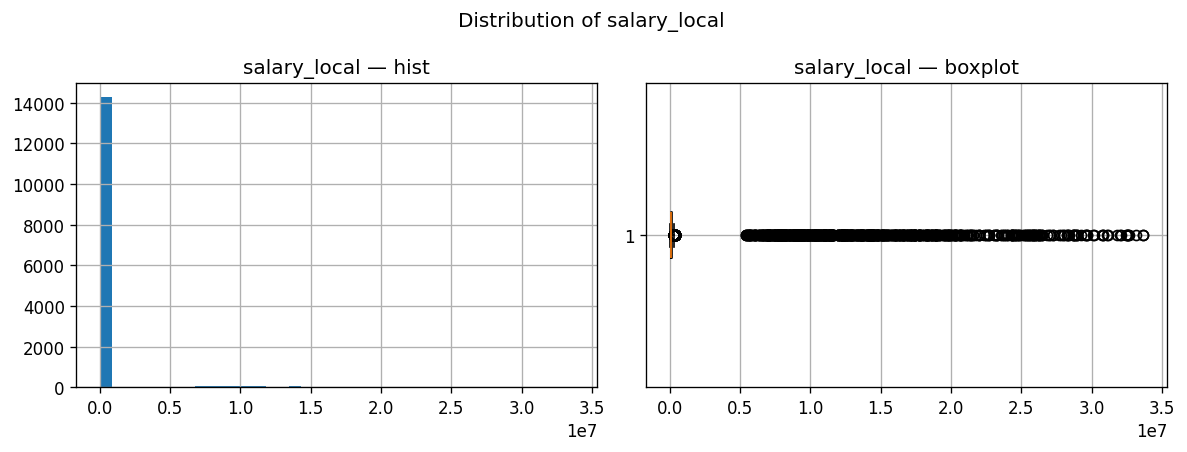

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\log1p_salary_local__hist.png


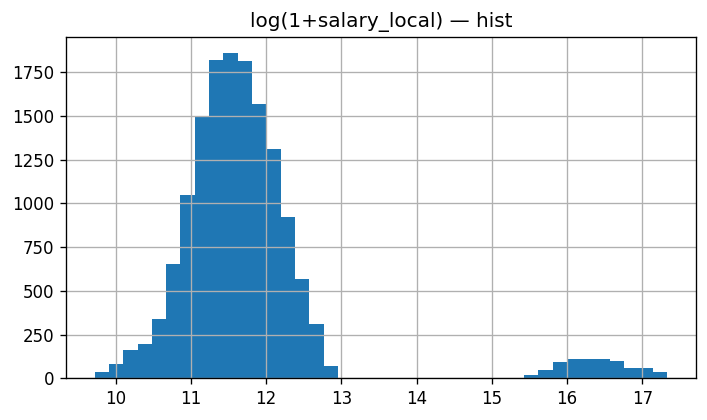

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\posting_year__hist_box.png


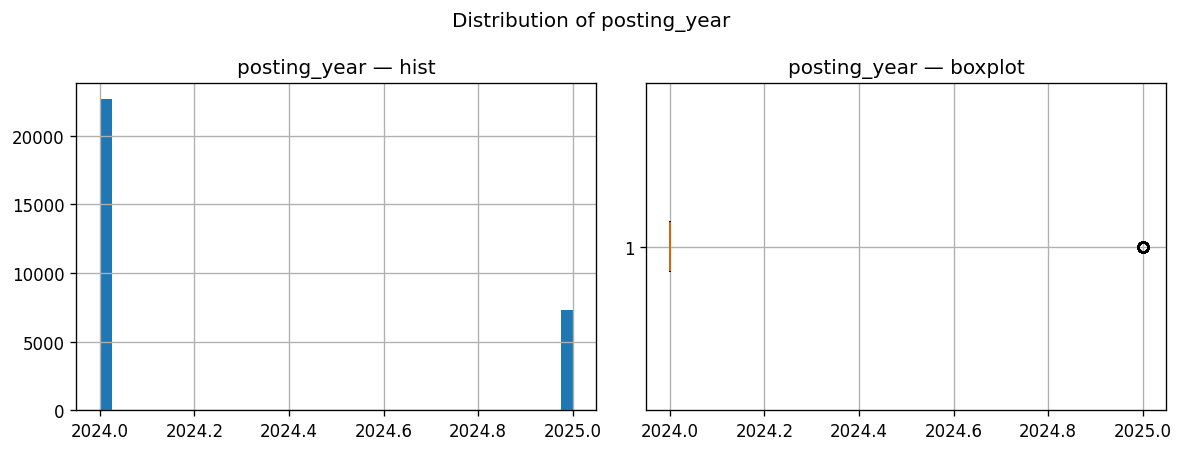

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\univariate\posting_month__hist_box.png


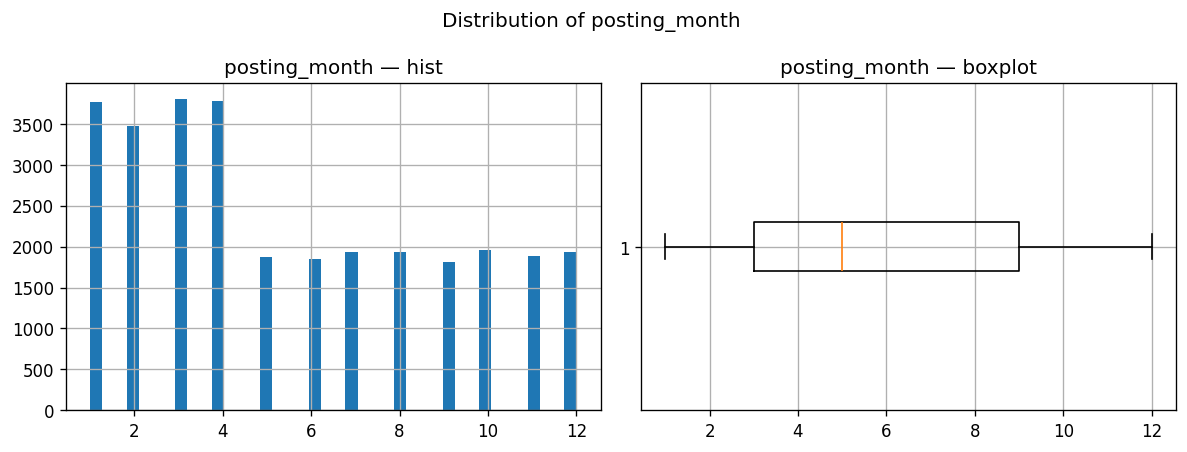

In [17]:
# ================================================================
# 5) UNIVARIATE ANALYSIS
# ================================================================

# Numeric distributions (hist + box + log view for skewed variables)
num_cols = [c for c in master.select_dtypes(include=[np.number]).columns if master[c].notna().sum() > 0]
print("Numeric columns:", num_cols)

def plot_numeric_distributions(df, cols, winsor=False):
    for c in cols:
        s = df[c].dropna()
        if s.empty: 
            continue
        if winsor:
            s = winsorize_series(s, 0.01, 0.99)
        
        # --- main hist + boxplot ---
        fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))
        ax[0].hist(s, bins=40)
        ax[0].set_title(f"{c} — hist")
        ax[1].boxplot(s, vert=False, showfliers=True)
        ax[1].set_title(f"{c} — boxplot")
        fig.suptitle(f"Distribution of {c} {'(winsorized 1–99%)' if winsor else ''}")
        plt.tight_layout()
        
        # ✅ Save the combined histogram+boxplot
        savefig(f"{c}__hist_box", section="univariate")

        plt.show()

        # --- log-scale view for skewed data ---
        if (s > 0).all() and s.max() / max(s.median(), 1e-9) > 5:
            plt.figure(figsize=(6,3.6))
            plt.hist(np.log1p(s), bins=40)
            plt.title(f"log(1+{c}) — hist")
            plt.tight_layout()
            
            # ✅ Save the log-transformed histogram
            savefig(f"log1p_{c}__hist", section="univariate")
            
            plt.show()

plot_numeric_distributions(master, num_cols, winsor=False)



**Observation → Implication (Univariate):**  
- Salaries typically show **right‑skew** → Log transformation stabilizes variance for fair comparisons.  
- Category columns often show **long‑tail** behavior → later plots should focus on **Top‑K** groups + “Other.”  


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\temporal\monthly_postings_trend.png


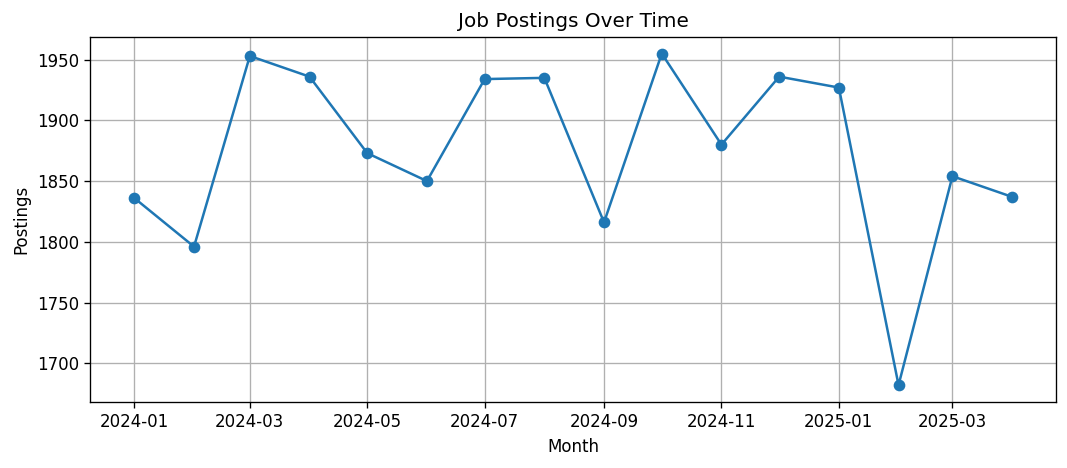

Recent activity (last 90 days): 18.28%


In [18]:
# ================================================================
# 6) TEMPORAL ANALYSIS 
# ================================================================
if "posting_date" in master.columns:
    # 1) Parse dates and keep only valid ones for time-series ops
    master["posting_date"] = safe_datetime(master["posting_date"])
    df_t = master.loc[master["posting_date"].notna()].copy()
    if df_t.empty:
        print("No valid posting_date values after parsing; skipping temporal analysis.")
    else:
        # 2) Derive year/month as INTEGERS (not floats)
        df_t["posting_year"]  = df_t["posting_date"].dt.year.astype("Int64")
        df_t["posting_month"] = df_t["posting_date"].dt.month.astype("Int64")

        # 3) Group by year-month
        monthly = (
            df_t.groupby(["posting_year","posting_month"])
                .size()
                .reset_index(name="count")
                .sort_values(["posting_year","posting_month"])
        )

        # 4) Build first-of-month dates safely (no string concat, no floats)
        monthly["date"] = pd.to_datetime({
            "year":  monthly["posting_year"].astype("Int64"),
            "month": monthly["posting_month"].astype("Int64"),
            "day":   1
        }, errors="coerce")

        # 5) Save + plot
        monthly.to_csv(TABLES / "monthly_postings.csv", index=False)

        plt.figure(figsize=(9,4))
        plt.plot(monthly["date"], monthly["count"], marker="o")
        plt.title("Job Postings Over Time")
        plt.xlabel("Month")
        plt.ylabel("Postings")
        plt.tight_layout()
        
        # ✅ Save the temporal trend chart
        savefig("monthly_postings_trend", section="temporal")
        
        plt.show()

        # 6) 90-day freshness KPI (use valid-date subset)
        pct_recent = 100.0 * (df_t["posting_date"] >= (df_t["posting_date"].max() - pd.Timedelta(days=90))).mean()
        print(f"Recent activity (last 90 days): {pct_recent:.2f}%")
else:
    print("No posting_date; skipping temporal analysis.")



**Interpretation (Temporal):**  
- Hiring demand often fluctuates; a short window limits seasonality claims.  
- Include a simple **“% in last 90 days”** KPI to indicate freshness of demand.  


Salary columns present: ['salary_usd']
💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary\salary_usd_by_experience_level.png


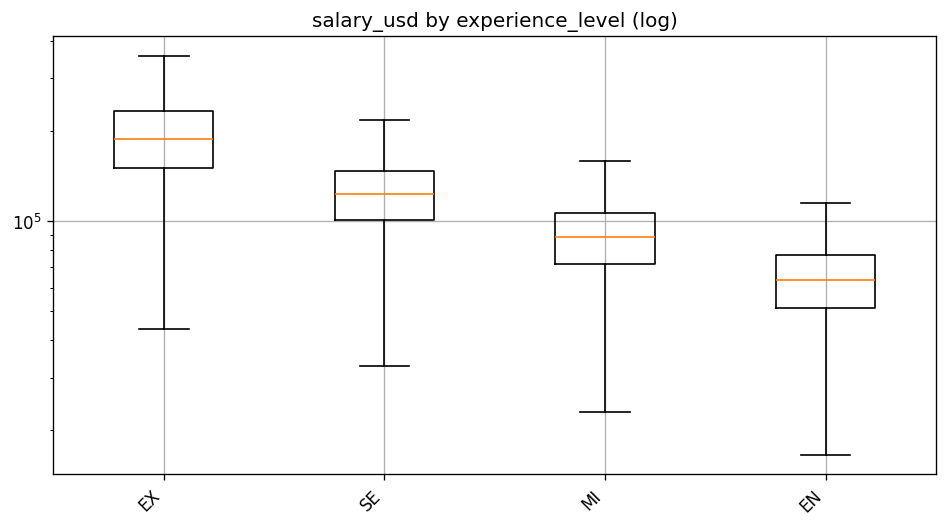

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary\salary_usd_by_employment_type.png


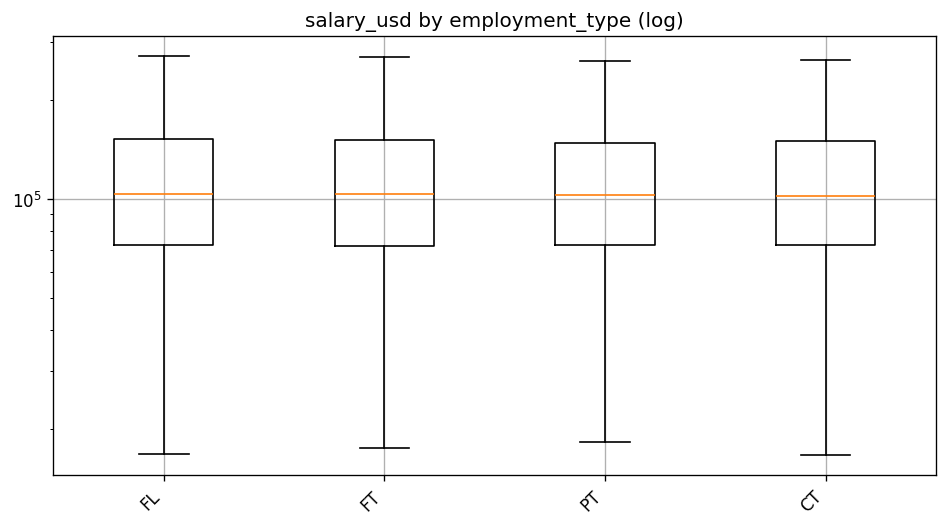

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary\salary_usd_by_work_setting.png


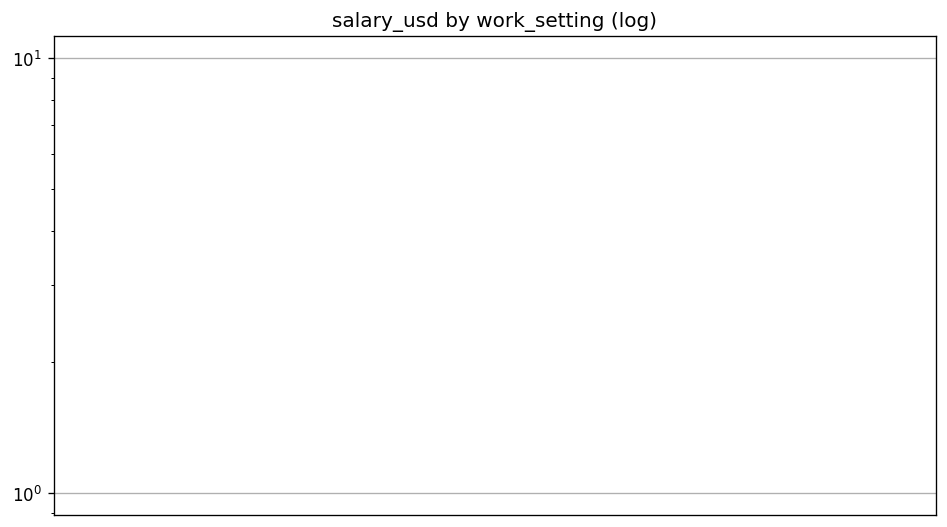

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\salary\log_salary_vs_remote_ratio.png


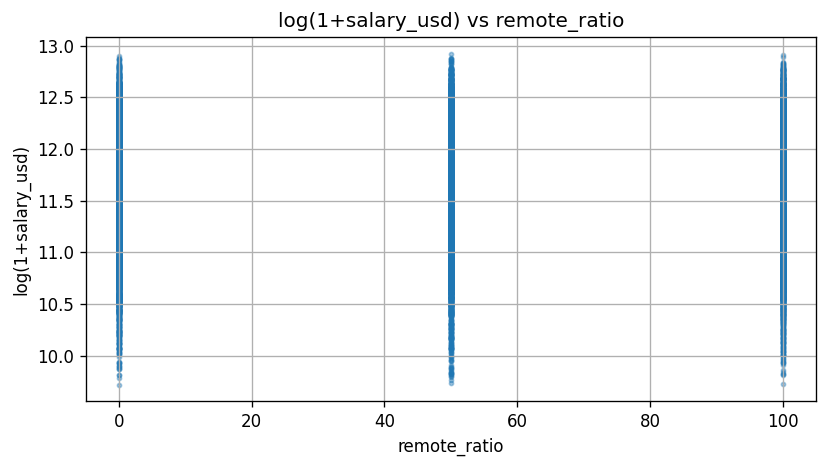

In [19]:
# ================================================================
# 7) SALARY LANDSCAPE
# ================================================================
cand_salary_cols = [c for c in ["salary_usd","salary_midpoint"] if c in master.columns]
print("Salary columns present:", cand_salary_cols)

def box_by_category(df, cat, val="salary_usd", log=True, top_k=None):
    if val not in df.columns or cat not in df.columns: 
        return
    tmp = df[[cat, val]].dropna()
    if top_k is not None and tmp[cat].nunique() > top_k:
        top = tmp[cat].value_counts().head(top_k).index
        tmp = tmp[tmp[cat].isin(top)]
    order = tmp.groupby(cat)[val].median().sort_values(ascending=False).index
    groups = [tmp[tmp[cat]==g][val].values for g in order]

    plt.figure(figsize=(max(8, len(order)*0.55), 4.5))
    plt.boxplot(groups, vert=True, showfliers=False)
    plt.xticks(range(1, len(order)+1), order, rotation=45, ha="right")
    if log:
        plt.yscale("log")
    plt.title(f"{val} by {cat} {'(log)' if log else ''}")
    plt.tight_layout()

    # ✅ Save each salary-by-category boxplot
    savefig(f"{val}_by_{cat}", section="salary")

    plt.show()

if "salary_usd" in cand_salary_cols:
    for cat in ["experience_level", "employment_type", "work_setting"]:
        if cat in master.columns:
            box_by_category(master, cat, "salary_usd", log=True, top_k=10)

# Remote vs onsite scatter
if "salary_usd" in master.columns and "remote_ratio" in master.columns:
    plt.figure(figsize=(7,4))
    plt.scatter(master["remote_ratio"], np.log1p(master["salary_usd"]), s=6, alpha=0.4)
    plt.title("log(1+salary_usd) vs remote_ratio")
    plt.xlabel("remote_ratio")
    plt.ylabel("log(1+salary_usd)")
    plt.tight_layout()

    # ✅ Save the remote-ratio scatterplot
    savefig("log_salary_vs_remote_ratio", section="salary")

    plt.show()



**Insight (Salary):**  
- Expect **clear median lift** from higher `experience_level`.  
- **Remote‑friendliness** can correlate with salary dispersion; treat as descriptive, not causal.  
- Use **log‑scale** to compare across roles without tail dominance.  


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\geo\top_hiring_locations.png


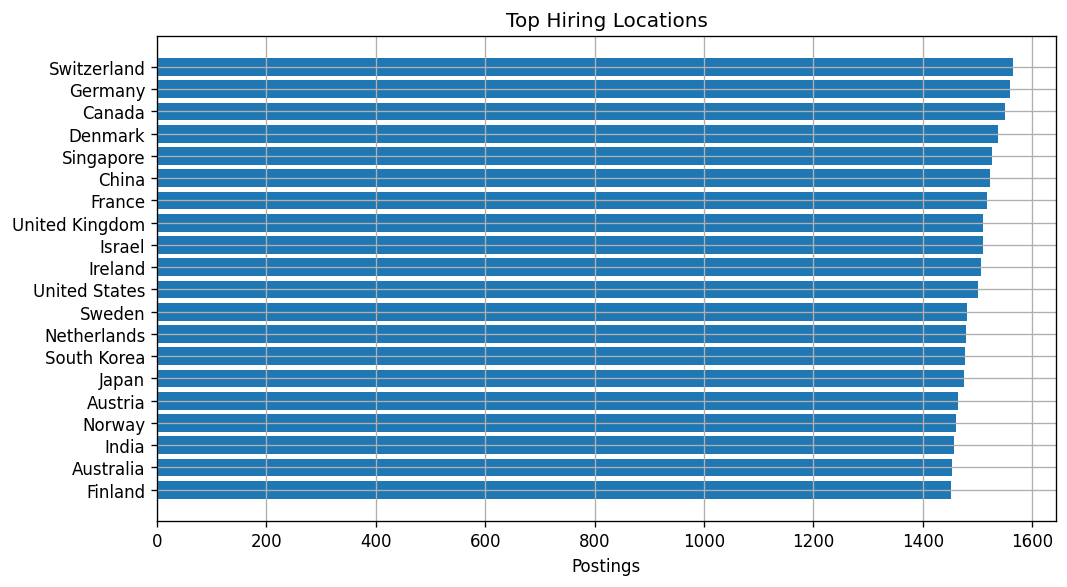

💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\geo\median_salary_by_location_top15.png


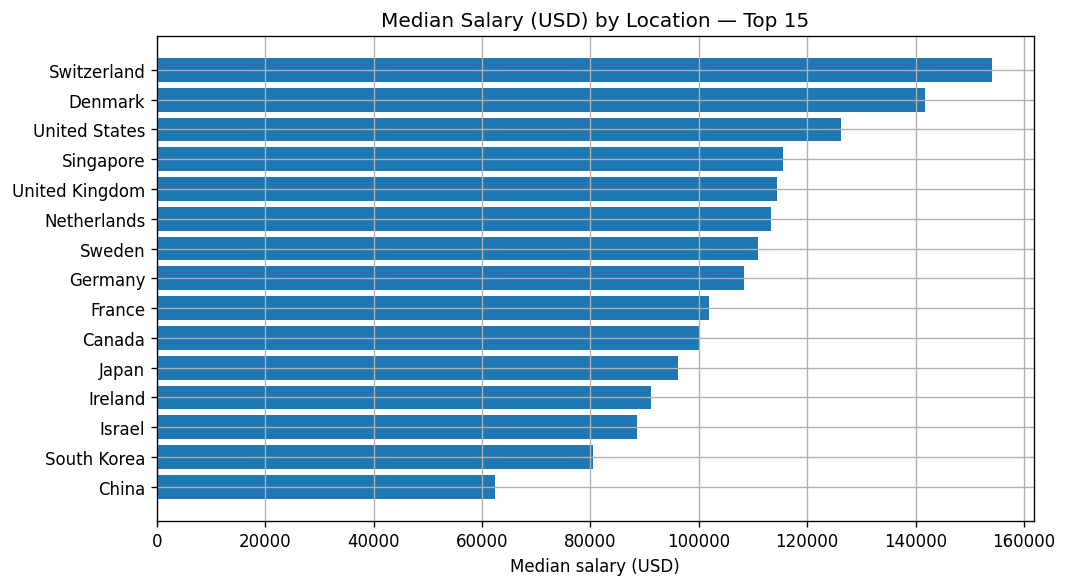

In [20]:
# ================================================================
# 8) GEOGRAPHIC ANALYSIS
# ================================================================
loc_col = "company_location" if "company_location" in master.columns else None
if loc_col:
    # --- Top hiring locations ---
    vc = master[loc_col].value_counts().head(20)
    vc.to_csv(TABLES / "top_hiring_locations.csv")
    plt.figure(figsize=(9,5))
    plt.barh(vc.index[::-1], vc.values[::-1])
    plt.title("Top Hiring Locations")
    plt.xlabel("Postings")
    plt.tight_layout()

    # ✅ Save the top hiring locations bar chart
    savefig("top_hiring_locations", section="geo")

    plt.show()

    # --- Median salary by location (top-K) ---
    if "salary_usd" in master.columns:
        tmp = master[[loc_col, "salary_usd"]].dropna()
        top = tmp[loc_col].value_counts().head(15).index
        tmp = tmp[tmp[loc_col].isin(top)]
        med = tmp.groupby(loc_col)["salary_usd"].median().sort_values(ascending=False)
        med.to_csv(TABLES / "median_salary_by_location.csv")

        plt.figure(figsize=(9,5))
        plt.barh(med.index[::-1], med.values[::-1])
        plt.title("Median Salary (USD) by Location — Top 15")
        plt.xlabel("Median salary (USD)")
        plt.tight_layout()

        # ✅ Save the median salary bar chart
        savefig("median_salary_by_location_top15", section="geo")

        plt.show()
else:
    print("No location column available; skipping geographic analysis.")



**Interpretation (Geography):**  
- Identify hiring hubs and compare **median salaries** across locations.  
- If remote share is high, also analyze `employee_residence` as the talent location lens.  


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\skills\top40_required_skills.png


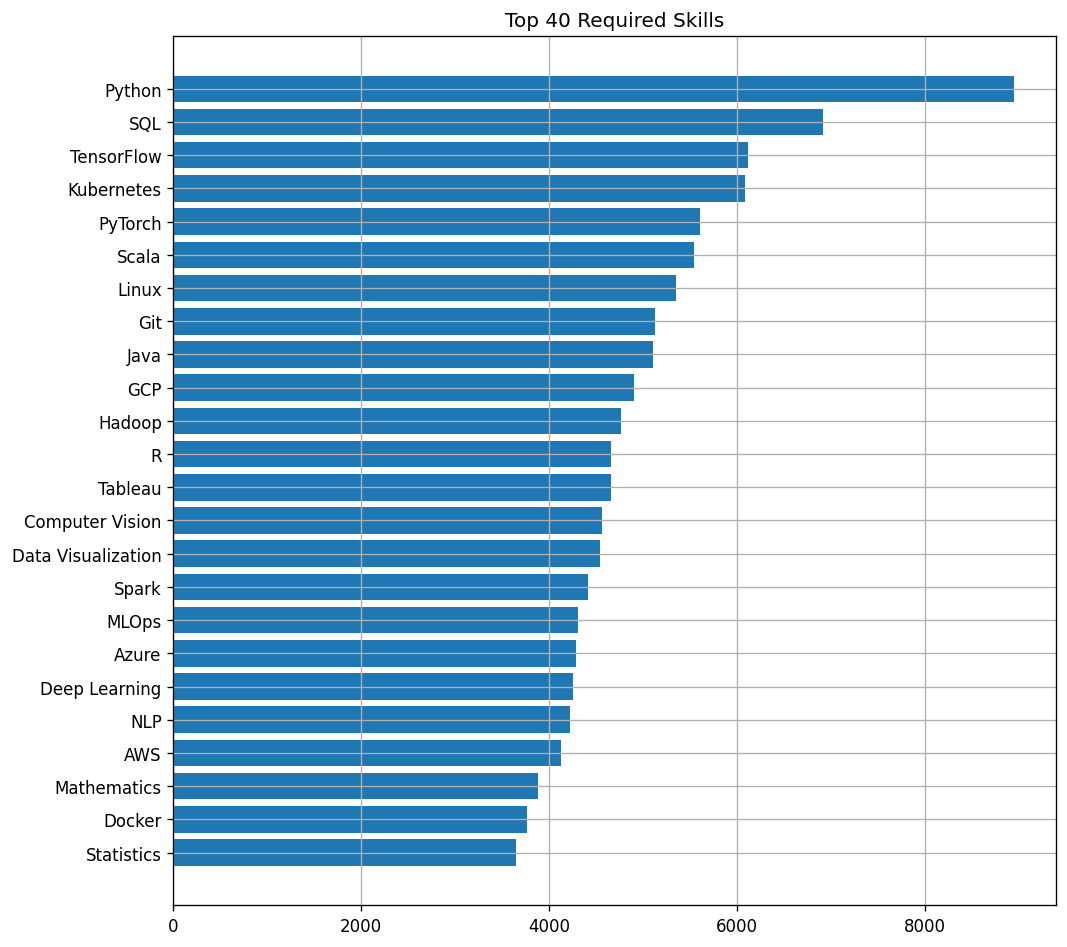

,skill,median_with,delta_vs_overall
19,NLP,104573.0,1366.5
22,Docker,104369.0,1162.5
7,Git,104238.0,1031.5
3,Kubernetes,103951.0,744.5
13,Computer Vision,103900.0,693.5
14,Data Visualization,103881.0,674.5
15,Spark,103835.0,628.5
18,Deep Learning,103762.0,555.5
10,Hadoop,103650.5,444.0
5,Scala,103610.0,403.5


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\skills\skill_cooccurrence_top30.png


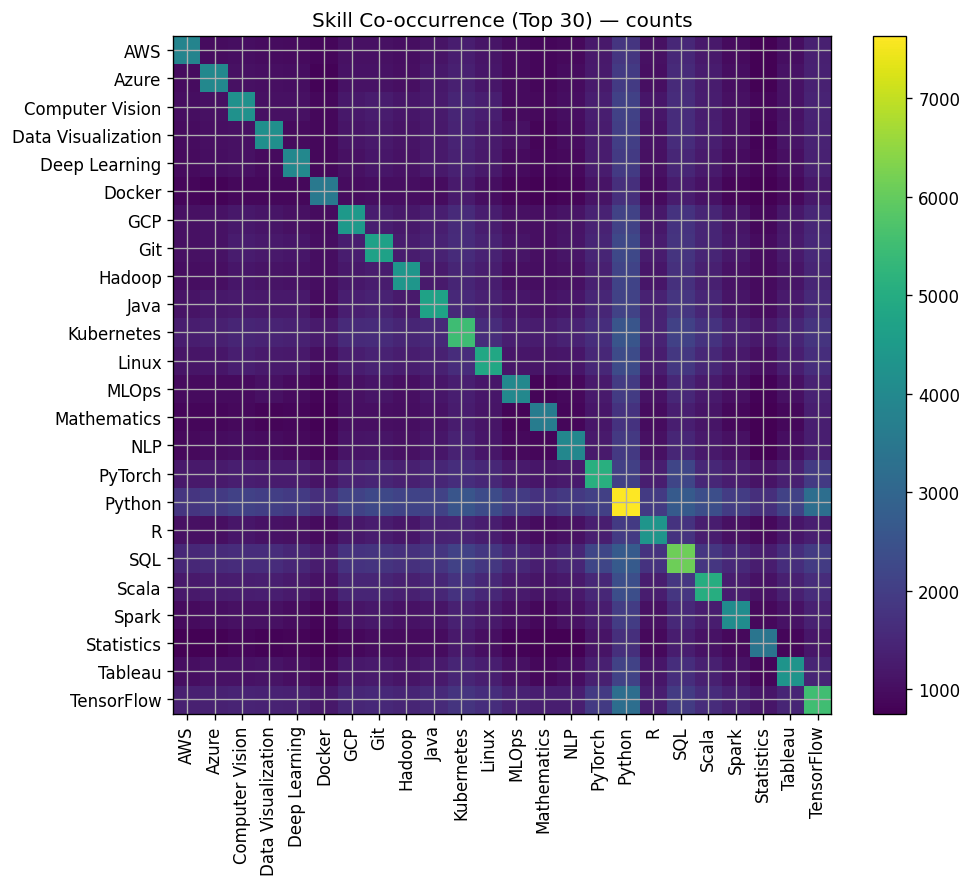

In [21]:
# ================================================================
# 9) SKILL DEMAND & CO-OCCURRENCE
# ================================================================
if "required_skills" in master.columns:
    skills_df = explode_skills(master, "required_skills")
    top_sk = skills_df["required_skills"].value_counts().head(40)
    top_sk.to_csv(TABLES / "top_skills.csv")

    # --- Top skills bar chart ---
    plt.figure(figsize=(9,8))
    plt.barh(top_sk.index[::-1], top_sk.values[::-1])
    plt.title("Top 40 Required Skills")
    plt.tight_layout()

    # ✅ Save top skills chart
    savefig("top40_required_skills", section="skills")

    plt.show()

    # --- Salary premium analysis (descriptive) ---
    if "salary_usd" in master.columns:
        records = []
        base_median = float(master["salary_usd"].median())
        post_idx = skills_df.index.unique()
        for skill, _ in top_sk.items():
            mask_rows = skills_df["required_skills"].eq(skill)
            idx_with = skills_df[mask_rows].index.unique()
            rows_with = master.loc[idx_with, "salary_usd"].dropna()
            if rows_with.empty:
                continue
            med_with = float(rows_with.median())
            records.append({
                "skill": skill,
                "median_with": med_with,
                "delta_vs_overall": med_with - base_median
            })
        skill_premium = pd.DataFrame(records).sort_values("median_with", ascending=False)
        skill_premium.to_csv(TABLES / "skill_salary_premium_descriptive.csv", index=False)
        display(skill_premium.head(10))

    # --- Skill co-occurrence heatmap ---
    cooc = cooccurrence_matrix(skills_df, "required_skills", top_k=30)
    cooc.to_csv(TABLES / "skill_cooccurrence_top30.csv")
    plt.figure(figsize=(8.5,7.5))
    plt.imshow(cooc.values, aspect="auto", interpolation="nearest")
    plt.xticks(range(len(cooc.columns)), cooc.columns, rotation=90)
    plt.yticks(range(len(cooc.index)), cooc.index)
    plt.title("Skill Co-occurrence (Top 30) — counts")
    plt.colorbar()
    plt.tight_layout()

    # ✅ Save the skill co-occurrence heatmap
    savefig("skill_cooccurrence_top30", section="skills")

    plt.show()
else:
    print("No 'required_skills' column; skipping skills analysis.")



**Observation → Implication (Skills):**  
- A few skills tend to **dominate** postings (power‑law).  
- **Bundles** (co‑occurrences) reveal curriculum paths (e.g., *Python + Pandas + SQL*).  
- The **salary premium** table is **descriptive** and can be confounded by role, seniority, or geography.  


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\relationships\spearman_correlation_numeric.png


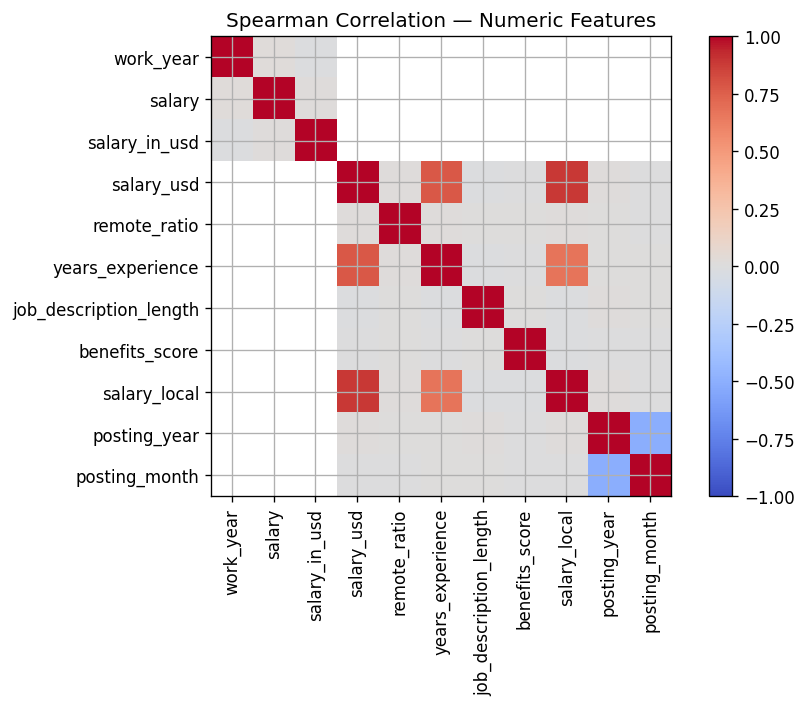

In [22]:
# ================================================================
# 10) RELATIONSHIPS (BIVARIATE/MULTIVARIATE)
# ================================================================

# --- Correlations among numeric features ---
num_cols = [c for c in master.select_dtypes(include=[np.number]).columns if master[c].notna().sum() > 0]
if len(num_cols) >= 2:
    corr = master[num_cols].corr(method="spearman")
    corr.to_csv(TABLES / "numeric_correlation_spearman.csv")

    plt.figure(figsize=(8,6))
    plt.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.colorbar()
    plt.title("Spearman Correlation — Numeric Features")
    plt.tight_layout()

    # ✅ Save the correlation heatmap
    savefig("spearman_correlation_numeric", section="relationships")

    plt.show()

# --- Salary vs skill_count scatter ---
if "salary_usd" in master.columns and "skill_count" in master.columns:
    tmp = master[["salary_usd", "skill_count"]].dropna()
    if not tmp.empty:
        plt.figure(figsize=(7,4))
        plt.scatter(tmp["skill_count"], np.log1p(tmp["salary_usd"]), alpha=0.35, s=8)
        plt.title("log(1+salary_usd) vs skill_count")
        plt.xlabel("skill_count")
        plt.ylabel("log(1+salary_usd)")
        plt.tight_layout()

        # ✅ Save the scatter plot
        savefig("log_salary_vs_skill_count", section="relationships")

        plt.show()



**Interpretation (Relationships):**  
- Correlations show **associations**, not mechanisms.  
- Use rank‑based (Spearman) for robustness to skew/outliers.  


💾 Saved figure → C:\Users\tdmne\OneDrive\Desktop\Projects 2\datathon-2025\outputs\figures\outliers\salary_usd_raw_vs_winsorized.png


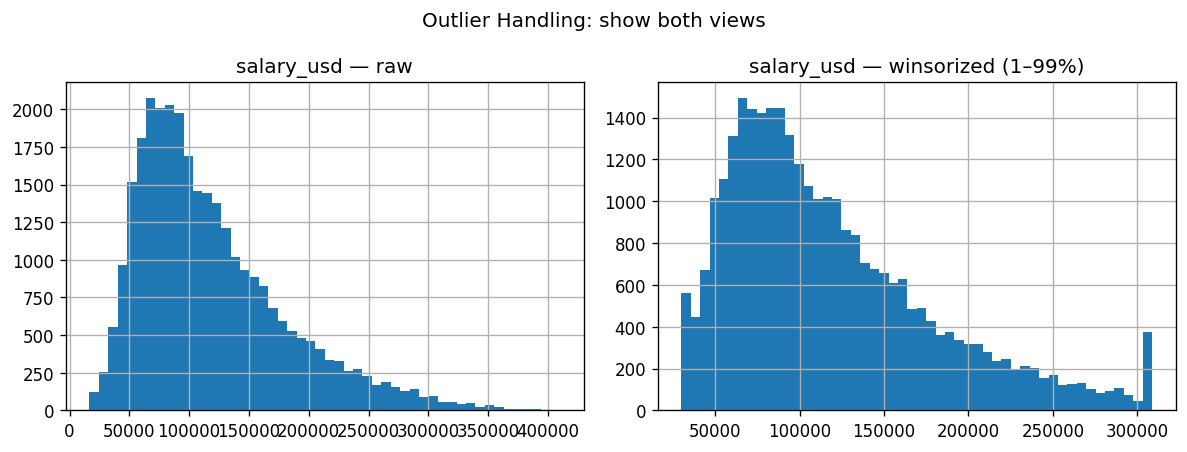

In [23]:
# ================================================================
# 11) OUTLIERS & ROBUSTNESS
# ================================================================
if "salary_usd" in master.columns:
    raw = master["salary_usd"].dropna()
    win = winsorize_series(raw, 0.01, 0.99)

    fig, ax = plt.subplots(1, 2, figsize=(10,3.8))
    ax[0].hist(raw, bins=50)
    ax[0].set_title("salary_usd — raw")
    ax[1].hist(win, bins=50)
    ax[1].set_title("salary_usd — winsorized (1–99%)")
    plt.suptitle("Outlier Handling: show both views")
    plt.tight_layout()

    # ✅ Save the outlier comparison histogram
    savefig("salary_usd_raw_vs_winsorized", section="outliers")

    plt.show()



**Policy:** We **do not delete** outliers by default. We display **raw** and **winsorized** views to avoid tail dominance while preserving reality.  



## 🧭 Insight Narratives (fill with your findings)

**Time:**  
- *Observation:* e.g., Postings rose sharply in Q1‑2025.  
- *Implication:* Focus on recent trends for dashboard filters (last 90 days).  

**Role × Experience (Salary):**  
- *Observation:* Senior roles show ~X× median vs Mid.  
- *Implication:* Highlight experience filter + salary bands.  

**Remote vs On‑site:**  
- *Observation:* Remote roles have higher dispersion.  
- *Implication:* Show a remote toggle on dashboard and explain spread.  

**Skills:**  
- *Observation:* Python/Pandas/SQL cluster dominates data roles; JS/React/Node clusters appear in ML‑prod roles.  
- *Implication:* Bundle‑aware learning paths in insights.  


In [ ]:

# ================================================================
# 12) HAND‑OFF & EXPORTS
# ================================================================
# Quick KPIs for report
kpis = {
    "rows_analyzed": int(len(master)),
    "n_columns": int(master.shape[1]),
    "median_salary_usd": float(master["salary_usd"].median()) if "salary_usd" in master.columns else None,
    "top_locations_example": master["company_location"].value_counts().head(5).to_dict() if "company_location" in master.columns else None,
    "top_skills_example": explode_skills(master)["required_skills"].value_counts().head(5).to_dict() if "required_skills" in master.columns else None,
    "recent_90d_share": None
}
if "posting_date" in master.columns:
    recent_cut = master["posting_date"].max() - pd.Timedelta(days=90)
    kpis["recent_90d_share"] = float((master["posting_date"] >= recent_cut).mean())

(REPORTS / "eda_kpis.json").write_text(json.dumps(kpis, indent=2))
print("✅ Wrote:", REPORTS / "eda_kpis.json")

print("\nNext steps → Phase 4 (Modeling):")
print("• Choose features suggested by EDA (experience_level, remote flags, top skill dummies, location)")
print("• Consider log(salary_usd) target for stability")
print("• Stratify by role/location if distributions differ wildly")



---

### ✅ Deliverables generated by this notebook
- Figures rendered inline (and saved tables in `/outputs/tables/` where applicable)  
- `reports/eda_summary.json` and `reports/eda_kpis.json` for quick reuse  
- CSV tables for: completeness, monthly postings, top locations, median salary by location, top skills, skill co‑occurrence, skill salary premium (descriptive)

